<a href="https://colab.research.google.com/github/varJATIN/Amazon-Food-Reviews-Summarization/blob/master/custom_archt_1_MA_CLAHE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.utils import shuffle
from matplotlib.pyplot import imread
from cv2 import resize
import matplotlib.pyplot as plt
import cv2
import scipy
## Seeding 
seed = 2
random.seed = seed
#np.random.seed = seed
tf.seed = seed

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1,drop=0.1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = tf.keras.layers.BatchNormalization()(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    c = keras.layers.Dropout(drop)(c)
    return c, p

def atten(x,g,F_x,F_g,F_int,kernel_size=(3,3), padding="same", strides=1):
    # upsample lower decoder filters
    us = keras.layers.UpSampling2D((2, 2))(g)
    gate = keras.layers.Conv2D(F_g, kernel_size, padding=padding, strides=strides, activation="relu")(us)
    gate=tf.keras.layers.BatchNormalization()(gate)
    
    # convolve the upsampled decoder filter for F_int filters
    W_g=keras.layers.Conv2D(F_int, kernel_size=1, padding=padding, strides=strides)(gate)
    W_g=tf.keras.layers.BatchNormalization()(W_g)
    
    # convolve encoder output for F_int filters
    W_x=keras.layers.Conv2D(F_int, kernel_size=1, padding=padding, strides=strides)(x)
    W_x=tf.keras.layers.BatchNormalization()(W_x)
    
    # convolve to  attention filter
    psi=tf.keras.activations.relu(W_x+W_g, alpha=0.0, max_value=None, threshold=0)
    psi=keras.layers.Conv2D(F_x, kernel_size=1, padding=padding, strides=strides)(psi)
    psi=tf.keras.activations.sigmoid(tf.keras.layers.BatchNormalization()(psi))
    
    # return the filtered encoder output for concat
    return x*psi

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1,drop=0.1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    us = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(us)
    us = tf.keras.layers.BatchNormalization()(us)
    # here skip is from encoder and x if from dec previous layer 
    filtered_skip=atten(skip,x,filters,filters,filters/2)
    #concat filtrd skip and upsampled us
    concat = keras.layers.Concatenate()([us, filtered_skip])
    c = keras.layers.Dropout(drop)(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c) 
    return c

In [4]:
def UNet_modular(depth=4,f=3,image_size=512):
    """ returns a modular code for the UNet multihead attention with
        deep supervision.
        depth is depth of model excluding bottleneck.
        f is no of filters in first layer.
        image_size is image pixel 
    """
    # define input container with 3 input channels
    input_channels=3
    inputs= keras.layers.Input((image_size, image_size, input_channels))
    pooled_out=inputs
    skip_memory=[]
    filters=[]
    for layer in range(depth):
      filters.append(f*2**layer)
    print(filters)

    for layer in range(depth):
      x,pooled_out=down_block(pooled_out,filters[layer])
      skip_memory.append(x)	

    # bottleneck_factor 
    bn_factor=2**depth
    upsample_out=bottleneck(pooled_out,f*bn_factor)
    upsample_memory=[upsample_out]
    for layer in range(depth):
      upsample_out=up_block(upsample_out,skip_memory[depth-1-layer],filters[depth-1-layer])
      upsample_memory.append(upsample_out)

    #up sample layer
    up=keras.layers.UpSampling2D((2,2))
    #create empty list for storing skip up samples 
    skip_up_list=[]
    # upsample the outputs of upsample layers stored in upsample_memory
    for i in range(depth):
      skip_up=upsample_memory[i]
      for j in range(depth-i):
        skip_up=up(skip_up)
      skip_up_list.append(skip_up)
    skip_up_list.append(upsample_memory[depth])
    deep_supervised = keras.layers.Concatenate()(skip_up_list)
    outputs=keras.layers.Conv2D(1,(1,1),padding="same",activation="sigmoid")(deep_supervised)
    model=keras.models.Model(inputs,outputs)
    return model


In [5]:
# data
data_location = "/content/drive/My Drive/IDRid/A. Segmentation/1. Original Images/a. Training Set"
train_data = []  # create an empty list
for (dirName, subdirList, fileList) in sorted(os.walk(data_location)):
    for fileName in sorted(fileList):
        if ".jpg" in fileName.lower() :
            train_data.append(os.path.join(dirName,fileName))
 
print(len(train_data))

# groundtruths for hard exudates
target_root_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/"
#data_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/3. Hard Exudates"
train_data_gt = []  # create an empty list
segs=['1. Microaneurysms','2. Haemorrhages','3. Hard Exudates','4. Soft Exudates']
for seg in segs:
  data_location=target_root_location+seg
  print(data_location)
  seg_mask=[]
  for dirName, subdirList, fileList in sorted(os.walk(data_location)):
      for filename in sorted(fileList):
          if ".tif" in filename.lower() :
              seg_mask.append(os.path.join(dirName,filename))
              #train_data_gt.append(os.path.join(dirName,filename))
  train_data_gt.append(seg_mask)
print(len(train_data_gt));

54
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/1. Microaneurysms
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/2. Haemorrhages
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/3. Hard Exudates
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/4. Soft Exudates
4


In [6]:
train_batch = np.zeros(shape = (len(train_data)*5, 640,640, 3));
train_label = np.zeros(shape = (len(train_data)*5, 640,640, 1));
rot=[-4,-3,-2,-1,1,2,3,4]
for file_index in range(0,len(train_data)*5,5):
    #print(file_index)
    # image
    img=imread(train_data[int(file_index/5)])
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(img[:,:,1])
    g_blur = cv2.GaussianBlur(cl1,(3,3),0)
    train_batch[file_index, :, :,:] = resize(img, (640,640))
    train_batch[file_index, :, :,1] = resize(g_blur, (640, 640))
    # label
    img = cv2.cvtColor(imread(train_data_gt[0][int(file_index/5)]), cv2.COLOR_BGRA2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    train_label[file_index, :, :,:] = np.expand_dims(resize(img, (640,640)), axis = 2)
    #print(np.max(train_batch),np.max(train_label))
    #flip
    train_batch[file_index+1, :, :,:]=np.flip(train_batch[file_index, :, :,:],axis=1)
    train_label[file_index+1, :, :,:]=np.flip(train_label[file_index, :, :,:],axis=1)
    #flip
    train_batch[file_index+2, :, :,:]=np.flip(train_batch[file_index, :, :,:],axis=0)
    train_label[file_index+2, :, :,:]=np.flip(train_label[file_index, :, :,:],axis=0)
    #rotate
    train_batch[file_index+3, :, :,:]=np.rot90(np.rot90(train_batch[file_index, :, :,:]))
    train_label[file_index+3, :, :,:]=np.rot90(np.rot90(train_label[file_index, :, :,:]))

    #random rotate
    ang=random.choice(rot)
    train_batch[file_index+4, :, :,:]=scipy.ndimage.rotate(train_batch[file_index, :, :,:],ang,reshape=False)
    train_label[file_index+4, :, :,:]=scipy.ndimage.rotate(train_label[file_index, :, :,:],ang,reshape=False)


train_batch[:,:,:,0]  = (train_batch[:,:,:,0])/np.max(train_batch)# - train_batch[:,:,:,0].min(axis=0)) / (train_batch[:,:,:,0].max(axis=0) - train_batch[:,:,:,0].min(axis=0)+1e-10)
train_batch[:,:,:,1]  = (train_batch[:,:,:,1])/np.max(train_batch)# - train_batch[:,:,:,1].min(axis=0)) / (train_batch[:,:,:,1].max(axis=0) - train_batch[:,:,:,1].min(axis=0)+1e-10)
train_batch[:,:,:,2]  = (train_batch[:,:,:,2])/np.max(train_batch)# - train_batch[:,:,:,2].min(axis=0)) / (train_batch[:,:,:,2].max(axis=0) - train_batch[:,:,:,2].min(axis=0)+1e-10)

train_label[:,:,:,0]  = (train_label[:,:,:,0])/np.max(train_label)# - train_label[:,:,:,0].min(axis=0)) / (train_label[:,:,:,0].max(axis=0) - train_label[:,:,:,0].min(axis=0)+1e-10)
mask = train_label[:,:,:,:] > 0.25
train_label[mask] = 1.0
train_label[~mask] = 0.0

print(train_batch.shape)
print(train_label.shape)

(270, 640, 640, 3)
(270, 640, 640, 1)


In [7]:
from keras import backend as K
def dice_loss(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return 1-dice

In [8]:
seed = 2
random.seed = seed
np.random.seed = seed
tf.seed = seed
tf.random.set_seed(2)
depths=[2,3,4]
models=[]
histories=[]
for f in [32]: 
  for depth in [2]:
    opt=keras.optimizers.Adam(learning_rate = 0.001,beta_1=0.08)
    model = UNet_modular(depth=depth,f=f,image_size=640) 
    model.compile(optimizer=opt, loss=dice_loss, metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])   
    early_stopping= tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta	=0.001, patience=8)
    hist = model.fit(x = train_batch, y = train_label, batch_size = 4, epochs = 200, verbose = 1, callbacks=[early_stopping], validation_split = 16/135, shuffle = True)
    models.append(model)
    histories.append(hist) 

[32, 64]
Epoch 1/200
60/60 [==============================] - 64s 871ms/step - loss: 0.9933 - mean_io_u: 0.4558 - val_loss: 0.9977 - val_mean_io_u: 0.4793
Epoch 2/200
60/60 [==============================] - 51s 856ms/step - loss: 0.9882 - mean_io_u: 0.4351 - val_loss: 0.9962 - val_mean_io_u: 0.1470
Epoch 3/200
60/60 [==============================] - 52s 875ms/step - loss: 0.9816 - mean_io_u: 0.4237 - val_loss: 0.9978 - val_mean_io_u: 0.3154
Epoch 4/200
60/60 [==============================] - 53s 890ms/step - loss: 0.9643 - mean_io_u: 0.4435 - val_loss: 0.9985 - val_mean_io_u: 0.4963
Epoch 5/200
60/60 [==============================] - 54s 901ms/step - loss: 0.9201 - mean_io_u: 0.4530 - val_loss: 0.9977 - val_mean_io_u: 0.3741
Epoch 6/200
60/60 [==============================] - 54s 909ms/step - loss: 0.9750 - mean_io_u: 0.4508 - val_loss: 0.9985 - val_mean_io_u: 0.4981
Epoch 7/200
60/60 [==============================] - 55s 919ms/step - loss: 0.8487 - mean_io_u: 0.4749 - val_loss: 

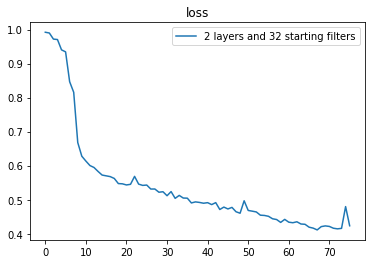

In [12]:
 j=0
k=0
for i,hist in enumerate(histories):
  plt.plot(hist.history['loss'],label="{} layers and {} starting filters".format(2,32))
  j+=1
  if j%3==0:
    j=0
    k+=1
plt.legend()
plt.title('loss')
plt.show()


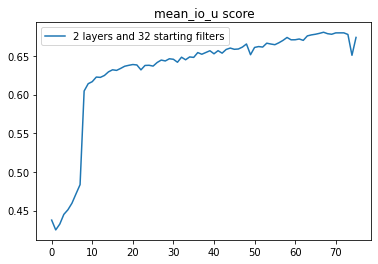

In [13]:
j=0
k=0
for i,hist in enumerate(histories):
  plt.plot(hist.history['mean_io_u_{}'.format(str(2))],label="{} layers and {} starting filters".format(2,32))
  j+=1
  if j%3==0:
    j=0
    k+=1
plt.legend()
plt.title('mean_io_u score')
plt.show()

#test data

In [14]:
# data
data_location = "/content/drive/My Drive/IDRid/A. Segmentation/1. Original Images/b. Testing Set"
test_data = []  # create an empty list
for (dirName, subdirList, fileList) in sorted(os.walk(data_location)):
    for fileName in sorted(fileList):
        if ".jpg" in fileName.lower() :
            test_data.append(os.path.join(dirName,fileName))
    
print(len(test_data))
target_root_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/"

test_data_gt = []  # create an empty list
segs=['1. Microaneurysms','2. Haemorrhages','3. Hard Exudates','4. Soft Exudates']
for seg in segs:
  data_location=target_root_location+seg
  print(data_location)
  seg_mask=[]
  for dirName, subdirList, fileList in sorted(os.walk(data_location)):
      for filename in sorted(fileList):
          if ".tif" in filename.lower() :
              seg_mask.append(os.path.join(dirName,filename))
              
  test_data_gt.append(seg_mask)
print(len(test_data_gt));

27
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/1. Microaneurysms
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/2. Haemorrhages
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/3. Hard Exudates
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/4. Soft Exudates
4


In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve,precision_score,recall_score

In [16]:
test_batch = np.zeros(shape = (len(test_data), 640,640, 3));
for file_index in range(0,len(test_data)):
    #print(file_index)
    # image
    img   = imread(test_data[file_index])
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(img[:,:,1])
    g_blur = cv2.GaussianBlur(cl1,(3,3),0)
    test_batch[file_index, :, :,:] = resize(img, (640, 640))
    test_batch[file_index, :, :,1] = resize(g_blur, (640,640))

# Normalize
test_batch  = test_batch/255
test_label = np.zeros(shape = (len(test_data_gt[0]), 640,640, 1));
# but i am filing the test_label serially ie if one mask is not there i am not leaving that place balnk but filing the next mask in its place
for file_index in range(0,len(test_data_gt[0])):  
  img = cv2.cvtColor(imread(test_data_gt[0][file_index]), cv2.COLOR_BGRA2BGR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  test_label[file_index, :, :,:] = np.expand_dims(resize(img, (640,640)), axis = 2)
# scale to 0-1
test_label[:,:,:,0]  = (test_label[:,:,:,0])/np.max(test_label)# - test_label[:,:,:,0].min(axis=0)) / (test_label[:,:,:,0].max(axis=0) - test_label[:,:,:,0].min(axis=0)+1e-10)
# binarize the masks
mask = test_label[:,:,:,:] > 0.25
test_label[mask] = 1
test_label[~mask] = 0

In [17]:
predicted_test_label=np.zeros(test_label.shape)
for i in range(27):
  #print(np.expand_dims(test_batch[i],axis=0).shape)
  predicted_test_label[i]=models[0].predict(np.expand_dims(test_batch[i],axis=0)) 

In [ ]:
#predicted_train_label=np.zeros((27,640,640,1))
#for i in range(27):
  #print(np.expand_dims(test_batch[i],axis=0).shape)
#  predicted_train_label[i]=model.predict(np.expand_dims(train_batch[i],axis=0))

2 layers  32 filter
train  0  test roc 0.8872759073708185
Train  F1 score: 0.000000 Test F1 score: 0.457479
Accuracy: 0.998875
natural threshold train AUPR 0  test AUPR 0.38620176168910525


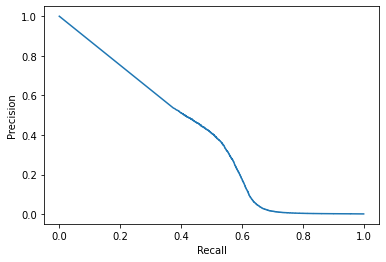

In [18]:
for j,model in enumerate(models):
  print(j+2, "layers ",32,"filter")
  predicted_test_label=np.zeros(test_label.shape)
  for i in range(27):
  #print(np.expand_dims(test_batch[i],axis=0).shape)
    predicted_test_label[i]=models[j].predict(np.expand_dims(test_batch[i],axis=0))
  #generate the masks
  
  #predicted_test_label=model.predict(test_batch)
  
  # ROC
  test_auc = roc_auc_score(test_label.reshape(-1),predicted_test_label.reshape(-1))
  #train_auc = roc_auc_score(train_label.reshape(-1),predicted_train_label.reshape(-1))
  print("train ",0," test roc",test_auc)

  # F1
  testy, yhat_classes=(test_label.reshape(-1),np.round(predicted_test_label.reshape(-1)))
  test_f1 = f1_score(testy, yhat_classes)
  #testy, yhat_classes=train_label.reshape(-1),np.round(predicted_train_label.reshape(-1))
  #train_f1 = f1_score(testy, yhat_classes)
  train_f1=0
  print('Train  F1 score: %f' % train_f1,'Test F1 score: %f' % test_f1)

  #accuracy
  accuracy = accuracy_score(testy, yhat_classes)
  print('Accuracy: %f' % accuracy)
  #AUPR
  
  test_aupr = precision_recall_curve(test_label.reshape(-1),predicted_test_label.reshape(-1))
  train_auc=0
  test_auc=auc(test_aupr[1],test_aupr[0] )
  print("natural threshold train AUPR",train_auc," test AUPR",test_auc)
  
  #plot Precision recall curve
  plt.plot(test_aupr[1],test_aupr[0])
  plt.ylabel('Precision')
  plt.xlabel('Recall')
  plt.show()
  #del predicted_test_label 

(640, 640, 1)


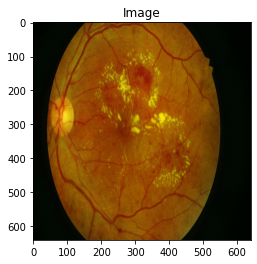

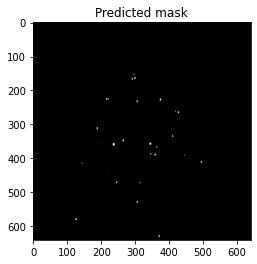

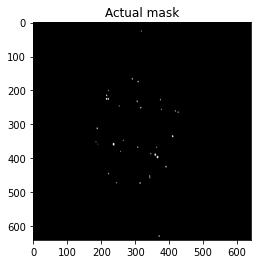

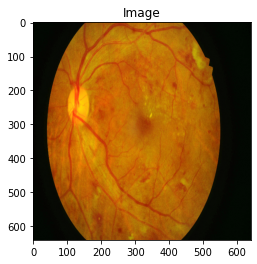

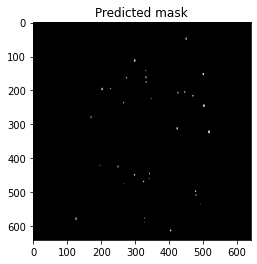

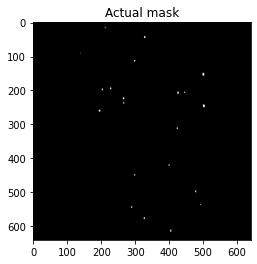

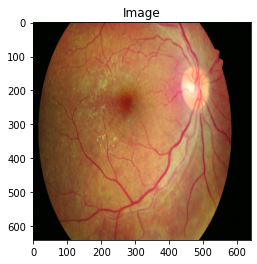

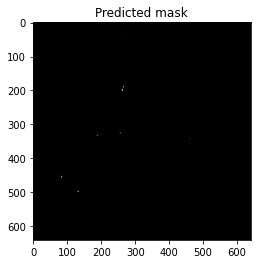

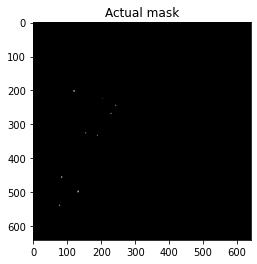

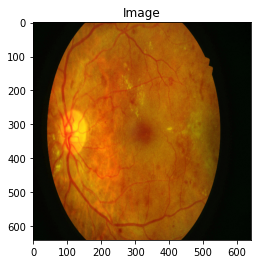

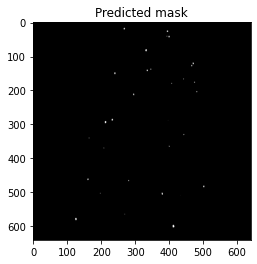

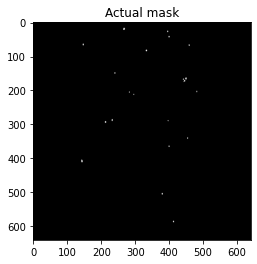

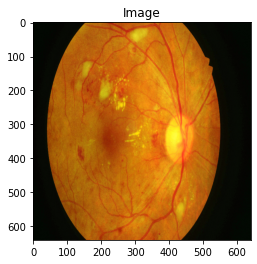

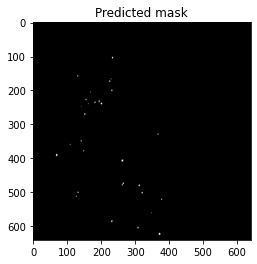

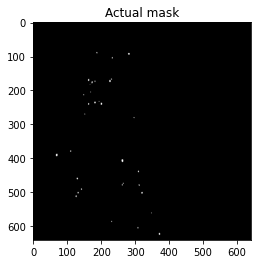

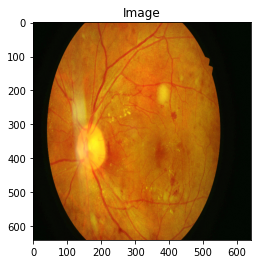

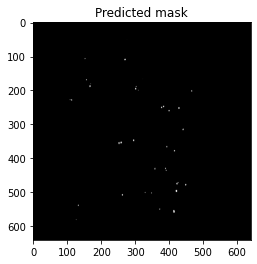

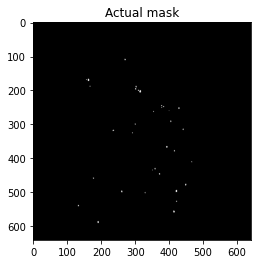

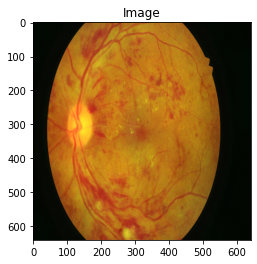

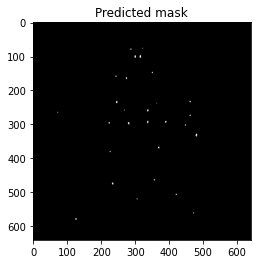

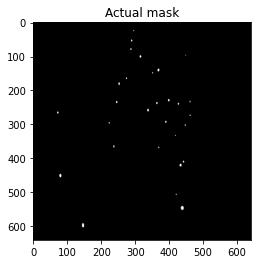

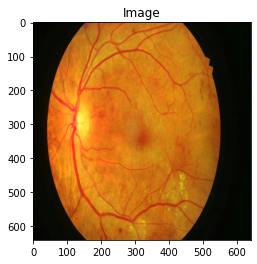

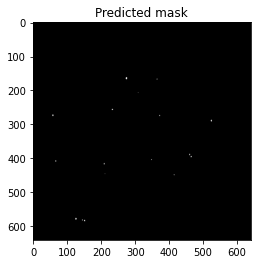

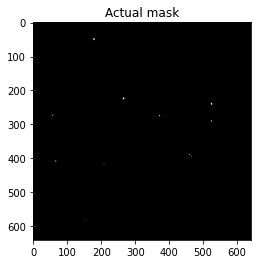

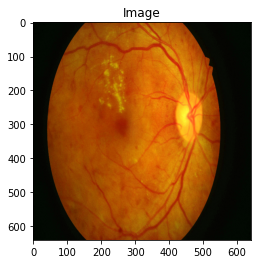

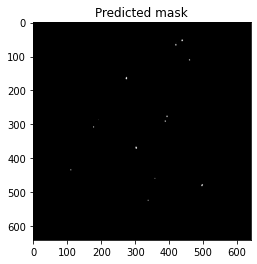

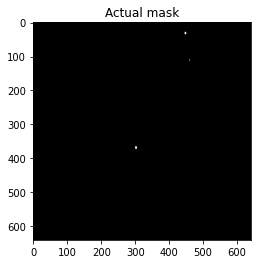

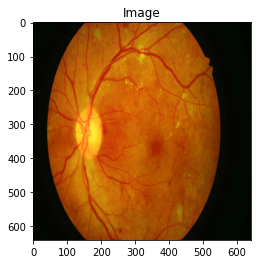

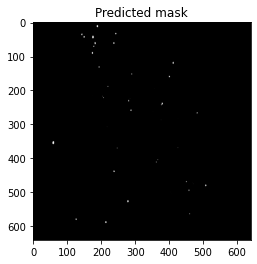

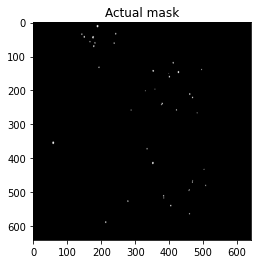

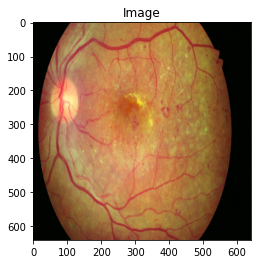

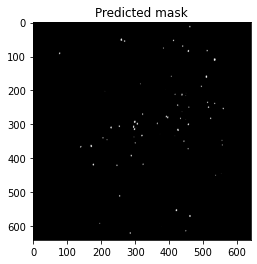

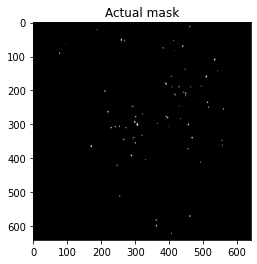

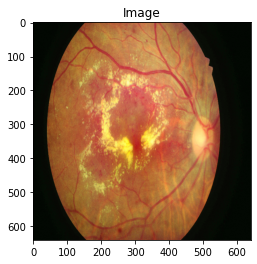

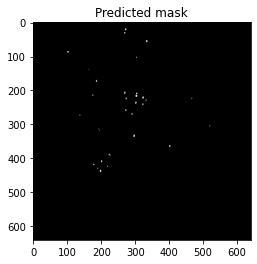

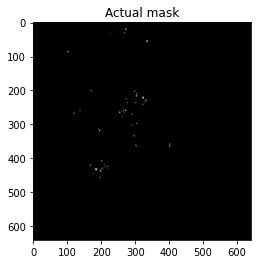

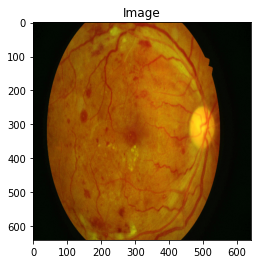

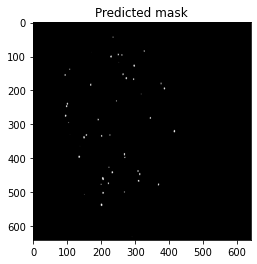

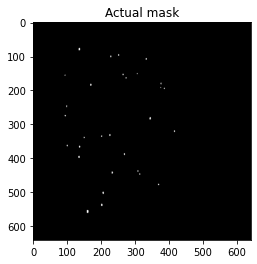

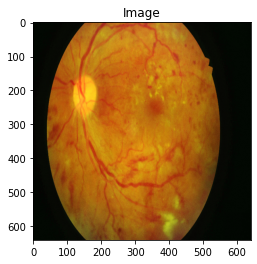

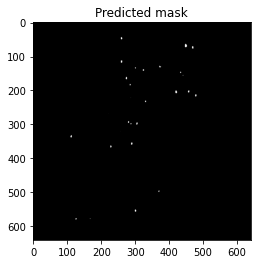

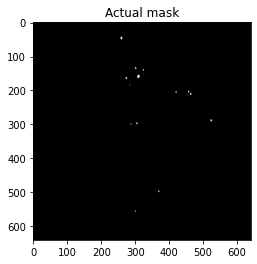

In [19]:
 #predicted_test_label=models[1].predict(test_batch)
print(predicted_test_label[0].shape)
for i in range(14):
    plt.imshow(test_batch[i,:,:,:])
    plt.title("Image")
    plt.show()  
    plt.imshow(np.squeeze(predicted_test_label[i,:,:,:], axis = 2),cmap='gray')
    plt.title("Predicted mask")
    plt.show()
    plt.imshow(np.squeeze(test_label[i,:,:,:], axis = 2), cmap='gray')
    plt.title("Actual mask")
    plt.show()

In [20]:
"""predicted_test_label=models[0].predict(test_batch)
print(predicted_test_label[0].shape)
for i in range(14):
    plt.imshow(test_batch[i,:,:,:])
    plt.title("Image")
    plt.show()  
    plt.imshow(np.squeeze(predicted_test_label[i,:,:,:], axis = 2),cmap='gray')
    plt.title("Predicted mask")
    plt.show()
    plt.imshow(np.squeeze(test_label[i,:,:,:], axis = 2), cmap='gray')
    plt.title("Actual mask")
    plt.show()"""

'predicted_test_label=models[0].predict(test_batch)\nprint(predicted_test_label[0].shape)\nfor i in range(14):\n    plt.imshow(test_batch[i,:,:,:])\n    plt.title("Image")\n    plt.show()  \n    plt.imshow(np.squeeze(predicted_test_label[i,:,:,:], axis = 2),cmap=\'gray\')\n    plt.title("Predicted mask")\n    plt.show()\n    plt.imshow(np.squeeze(test_label[i,:,:,:], axis = 2), cmap=\'gray\')\n    plt.title("Actual mask")\n    plt.show()'